# Following the Climate Change

This Jupyter / PySpark notebook tries to "manually" investigate by analyzing publicly available raw measurements data. The basic idea is to perform all investigations on relatively raw measurements data instead of simply citing the results of some renowed institutions.

The whole notebook is meant to be a non-trivial real-world example for working with PySpark. It has several interesting aspects:
* It processes a non-trivial amount of data, which justifies using PySpark
* It works with real-world data providing several different challenges
* The topic itself is of general interest

# Disclaimer

I am neither an expert for meteorology nor for climate models. I will try to use common sense to gather some insights. Eventually this was part of my idea: Everyone who has some experience with working with data should be able to perform some conclusions on the climate change given a detailed enough data set.

I will add some remarks where I know that things are not correct. As far as I know real expert would go down a completely different route and build a weather model from the given measurements and then interpolate the weather evenly across the whole earth. This is completely out of scope of this article, we instead will use simple averages of the measurements per country.

# Prerequisistes

Before following the notebook, you need to setup an appropriate environment. This includes both the correct software stack and enough hardware to work with the data.

### Software requirements

This notebook requires Jupyter and PySpark. An `environment.yml` file for setting up an appropriate Anaconda environment is part of the repository. You can create an environment via

```sh
conda env create -n weather -f environment.yml
```
Then you can activate the environment and start the Jupyter Lab server via
```sh
conda activate weather
jupyter-lab  --ip=0.0.0.0 --port=8888  
```

### Hardware recommendations

The weather data is huge, it consists of 100GB compressed data. So a fast machine with lots of RAM and plenty of fast storage is recommended for following the analysis.
* Fast machine, many cores. I used a single machine with 20 cores with hyperthreading (i.e. 40 threads) with 64GB of RAM
* At least 300GB of free disk space (100 GB for NOAA archive, 50 GB for intermediate results and 150 GB for Spark scratch space)
* Working Jupyter Notebook with PySpark (I used 3.0, but 2.4 should also work fine)

# 0. Getting the Data

I decided to use the very broad and detailed raw weather measuremets data provided by the [National Oceanic and Atmospheric Administration](https://www.noaa.gov/) (NOAA). The data is publicly available, contains the raw measurements from weather stations around the world and goes back in history to 1901. This should provide a very solid basis for our investigations.

First you need to download all the data onto your machine. The data can be retrieved from the NOAA ftp server at ftp://ftp.ncdc.noaa.gov/pub/data/noaa  or at ftp://ftp.ncei.noaa.gov/pub/data/noaa/. You need to download all year directories (1901 until present, i.e. 2020) and the file `isd-history.csv`. In addition I highly recommend to download the documentation `isd-format-document.pdf`, which contains many important details for interpreting the data.

Be patient when downloading the data, I think it took almost two days until I fetched all the 100GB of compressed data. (FTP isn't the fastest protocol for many small files plus the servers only allow for two connections per source IP address).

# 1. Notebook Setup

Once you have downloaded all the data onto your local machine, you can continue with this notebook

## Imports

In the first step, we only important some Python packages and create a Spark session.

In [1]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels as sm

## Directories

Here we setup the directories which point to the source data and to intermediate directories. Note that we also set a `spark_tempdir` directory where Spark can spill data to. That directory should have at least 150GB of free space.

In [2]:
# Source directory where all downloaded data is stored in
weather_basedir = "file:///dimajix/data/weather-noaa"

# Output directory for intermediate results and aggregations
structured_basedir = "file:///srv/ssd/dimajix/weather-dwh"

# Temporary directory for Spark
spark_tempdir = "/srv/ssd/tmp/jupyter-spark"

The intermediate directories are located below the `structured_basedir` path and will contain derived data. Since our data set is rather large, persisting intermediate transformations and preaggregates will speed up our work significantly.

In [3]:
hourly_weather_location = os.path.join(structured_basedir, "weather-measurements")
stations_location = os.path.join(structured_basedir, "weather-stations")
daily_weather_location = os.path.join(structured_basedir, "daily-weather-measurements")
daily_country_weather_location = os.path.join(structured_basedir, "daily-country-weather-measurements")

## Utility Functions

In [4]:
from urllib.parse import urlparse
from fs import open_fs

def path_exists(path):
    url = urlparse(path, scheme="file")
    with open_fs(url.scheme + "://" + url.netloc + "/") as fs:
        return fs.exists(url.path)

## Spark Session

Finally a Spark session is created. You might want to adjust the settings, I used Spark local mode with 48GB RAM.

In [5]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

if not 'spark' in locals():
    spark = SparkSession.builder \
        .master("local[*]") \
        .config("spark.driver.memory","48G") \
        .config("spark.local.dir", spark_tempdir) \
        .getOrCreate()

spark

# 2. Data Preparation

The data we use is the so called *Integrated Surface Hourly" data set from the NOAA. This means that it contains hourly measurements of surface based weather stations (as opposed to weather information taken above the surface like via air planes or weather balloons).

Before analysing the data, we will perform a technical format conversion into Parquet files. The original data files are stored as CSV (for the master data) and a proprietary and complex text based format for the measurememts themselves. Storing the data as Parquet files makes the data much easier accessible and will also significantly speed up processing, since Parquet was designed for this type of access patterns.

## 2.1 Master Data

First we process the master data containing meta information about all weather stations. We require this data in order to associate a country with each weather stations, which are only marked by some identifiers in the measurements themselves.

The master data contains several columns of importance for us
* The columns `USAF` and `WBAN` contain weather station IDs. Since not all stations have a valid id for each of these coolumns, we can only assume the combination of both of these columns to be unique per weather station
* The column `CTRY` contains the FIPS code of the country the weather station belongs to. Be aware of the fact that these codes are *not* ISO codes, but FIPS codes instead: https://en.wikipedia.org/wiki/List_of_FIPS_country_codes
* The columns `BEGIN` and `END` mark the life span of each weather station. Remember, we have data going back to 1901, so most weather stations will not exist for the whole time span.
* `LAT` and `LON` contain the geo coordinates of the weather station. We won't use them.

### Reading Master Data

The master data is provided as a simle CSV file, so we can directly read it with PySpark `spark.read.csv` method as follows:

In [7]:
weather_stations = spark.read \
    .option("header", True) \
    .csv(weather_basedir + "/isd-history.csv")

weather_stations.limit(10).toPandas()

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
0,007018,99999,WXPOD 7018,None,None,None,+00.000,+000.000,+7018.0,20110309,20130730
1,007026,99999,WXPOD 7026,AF,None,None,+00.000,+000.000,+7026.0,20120713,20170822
2,007070,99999,WXPOD 7070,AF,None,None,+00.000,+000.000,+7070.0,20140923,20150926
3,008260,99999,WXPOD8270,None,None,None,+00.000,+000.000,+0000.0,20050101,20100920
4,008268,99999,WXPOD8278,AF,None,None,+32.950,+065.567,+1156.7,20100519,20120323
5,008307,99999,WXPOD 8318,AF,None,None,+00.000,+000.000,+8318.0,20100421,20100421
6,008411,99999,XM20,None,None,None,None,None,None,20160217,20160217
7,008414,99999,XM18,None,None,None,None,None,None,20160216,20160217
8,008415,99999,XM21,None,None,None,None,None,None,20160217,20200314
9,008418,99999,XM24,None,None,None,None,None,None,20160217,20160217


### Saving Master Data

Once we have read in the CSV file, we will rename some columns (which contain special characters) and save the result as Parquet files.

In [7]:
weather_stations = weather_stations \
    .withColumnRenamed("STATION NAME", "STATION_NAME") \
    .withColumnRenamed("ELEV(M)", "ELEVATION")

weather_stations.write.mode("overwrite").parquet(stations_location)

## 2.2 Measurements

Now let's have a look at the measurements themselves. The measurements are stored in individual files per weather station and they are organized in different sub directories for the different years. As we will soon see, the format is rather complex, but some information can be extracted using some simple Spark SQL functions.

In order to get a feeling for the data, we first start reading a single directory and dump its contents. Since the format is not CSV but still text based (i.e. each record is a separate line in each file), we use `spark.read.text` for reading the raw measurements data:

In [6]:
raw_weather = spark.read.text(weather_basedir + "/2013")
raw_weather.limit(10).toPandas()

,value
0,042599999963897201301010000I+32335-086979CRN05...
1,013399999963897201301010005I+32335-086979CRN05...
2,013399999963897201301010010I+32335-086979CRN05...
3,013399999963897201301010015I+32335-086979CRN05...
4,013399999963897201301010020I+32335-086979CRN05...
5,013399999963897201301010025I+32335-086979CRN05...
6,013399999963897201301010030I+32335-086979CRN05...
7,013399999963897201301010035I+32335-086979CRN05...
8,013399999963897201301010040I+32335-086979CRN05...
9,013399999963897201301010045I+32335-086979CRN05...


### Wind and Temperature Extraction

As we just saw, the raw data is a stream of ASCII characters. Some basic metrics can be extracted at fixed locations while some other information is stored at dynamic locations. The documentation of the ISD file contains details where some basic information like wind speed and air temperature is stored at. 

We start with extracting some information, which is easily accessible at fixed locations. This will give us the stations identifiers, a time stamp (date and time), wind speed and direction and air temperature. 

Note that in addition to the measurements themselves we also extract *quality indicators* for each measurements. These indicators are also described in the official documentation and tell us if each metric of each measurement is valid or not. There are multiple different scenarios which result in partially invalid measurements:
* A weather station might not have all sensors. For example a certain weather station might only measure temperature but not wind speed.
* One of the sensors of a weather station might be broken while the other is still working fine.
* Different sensors are collected in different time intervals.

In order to extract the different information, we mainly use the PySpark SQL function `substring` and cast the result to an appropriate data type. We also incorporate any required scaling for temperature and wind speed.

In [7]:
raw_weather.select(
        f.substring(raw_weather["value"],5,6).alias("usaf"),
        f.substring(raw_weather["value"],11,5).alias("wban"),
        f.to_timestamp(f.substring(raw_weather["value"],16,12), "yyyyMMddHHmm").alias("ts"),
        f.substring(raw_weather["value"],42,5).alias("report_type"),
        f.substring(raw_weather["value"],61,3).alias("wind_direction"),
        f.substring(raw_weather["value"],64,1).alias("wind_direction_qual"),
        f.substring(raw_weather["value"],65,1).alias("wind_observation"),
        (f.substring(raw_weather["value"],66,4).cast("float") / 10.0).alias("wind_speed"),
        f.substring(raw_weather["value"],70,1).alias("wind_speed_qual"),
        (f.substring(raw_weather["value"],88,5).cast("float") / 10.0).alias("air_temperature"),
        f.substring(raw_weather["value"],93,1).alias("air_temperature_qual")
    ) \
    .withColumn("date", f.to_date(f.col("ts"))) \
    .limit(10).toPandas()

,usaf,wban,ts,report_type,wind_direction,wind_direction_qual,wind_observation,wind_speed,wind_speed_qual,air_temperature,air_temperature_qual,date
0,999999,63897,2013-01-01 00:00:00,CRN05,124,1,H,0.9,1,10.6,1,2013-01-01
1,999999,63897,2013-01-01 00:05:00,CRN05,124,1,H,1.5,1,10.6,1,2013-01-01
2,999999,63897,2013-01-01 00:10:00,CRN05,122,1,H,1.7,1,10.4,1,2013-01-01
3,999999,63897,2013-01-01 00:15:00,CRN05,120,1,H,1.7,1,11.0,1,2013-01-01
4,999999,63897,2013-01-01 00:20:00,CRN05,120,1,H,1.7,1,10.9,1,2013-01-01
5,999999,63897,2013-01-01 00:25:00,CRN05,124,1,H,1.7,1,11.2,1,2013-01-01
6,999999,63897,2013-01-01 00:30:00,CRN05,121,1,H,2.0,1,11.2,1,2013-01-01
7,999999,63897,2013-01-01 00:35:00,CRN05,120,1,H,2.2,1,11.4,1,2013-01-01
8,999999,63897,2013-01-01 00:40:00,CRN05,122,1,H,2.5,1,11.5,1,2013-01-01
9,999999,63897,2013-01-01 00:45:00,CRN05,127,1,H,2.9,1,11.6,1,2013-01-01


### Precipitation Extraction

Precipitation is more difficult to extract, since the data is optional and contained at variable locations. We still refuse to use user defined functions (UDFs) and use `substr` expressions instead. Actually each measurement can have up to four precipitation measurements for different time spans (hourly, daily, monthly).

Since the interpretation is also non-trivial (in other words, I don't understand enough to make sense of it), we will not make any use of it.

In [17]:
def extract_precipitation(df, index, start_position):
    column = f"AA{index}"
    return df.withColumn(column, f.when(f.substring(raw_weather["value"], start_position, 3) == f.lit(f"AA{index}"),f.substring(raw_weather["value"], start_position+3, 8) )) \
        .withColumn(f"precipitation_hours_{index}", f.substring(f.col(column), 1, 2).cast("INT")) \
        .withColumn(f"precipitation_depth_{index}", f.substring(f.col(column), 3, 4).cast("FLOAT")) \
        .withColumn(f"precipitation_cond_{index}", f.substring(f.col(column), 7, 1)) \
        .withColumn(f"precipitation_qual_{index}", f.substring(f.col(column), 8, 1)) \
        .drop(column)

# Perform extraction for all four possible precipitation measurements
df = extract_precipitation(raw_weather, 1, 109)
df = extract_precipitation(df, 2, 120)
df = extract_precipitation(df, 3, 131)
df = extract_precipitation(df, 4, 142)

# Dump some records which contain specific condition codes
df.filter("AA1 IS NOT NULL AND precipitation_cond_1 == '9' AND precipitation_depth_1 > 0") \
        .limit(10).toPandas()

,value,precipitation_hours_1,precipitation_depth_1,precipitation_cond_1,precipitation_qual_1,precipitation_hours_2,precipitation_depth_2,precipitation_cond_2,precipitation_qual_2,precipitation_hours_3,precipitation_depth_3,precipitation_cond_3,precipitation_qual_3,precipitation_hours_4,precipitation_depth_4,precipitation_cond_4,precipitation_qual_4
0,042599999963897201301012000I+32335-086979CRN05...,1,2.0,9,1,NaN,NaN,None,None,NaN,NaN,None,None,NaN,NaN,None,None
1,042599999963897201301012100I+32335-086979CRN05...,1,6.0,9,1,NaN,NaN,None,None,NaN,NaN,None,None,NaN,NaN,None,None
2,042599999963897201301012200I+32335-086979CRN05...,1,84.0,9,1,NaN,NaN,None,None,NaN,NaN,None,None,NaN,NaN,None,None
3,042599999963897201301012300I+32335-086979CRN05...,1,25.0,9,1,NaN,NaN,None,None,NaN,NaN,None,None,NaN,NaN,None,None
4,042599999963897201301020000I+32335-086979CRN05...,1,4.0,9,1,NaN,NaN,None,None,NaN,NaN,None,None,NaN,NaN,None,None
5,042599999963897201301020100I+32335-086979CRN05...,1,5.0,9,1,NaN,NaN,None,None,NaN,NaN,None,None,NaN,NaN,None,None
6,042599999963897201301020200I+32335-086979CRN05...,1,14.0,9,1,NaN,NaN,None,None,NaN,NaN,None,None,NaN,NaN,None,None
7,042599999963897201301020300I+32335-086979CRN05...,1,5.0,9,1,NaN,NaN,None,None,NaN,NaN,None,None,NaN,NaN,None,None
8,042599999963897201301020400I+32335-086979CRN05...,1,4.0,9,1,NaN,NaN,None,None,NaN,NaN,None,None,NaN,NaN,None,None
9,004899999963897201301020559I+32335-086979SOD ...,24,149.0,9,1,NaN,NaN,None,None,NaN,NaN,None,None,NaN,NaN,None,None


### Complete Extraction

Now we can put together both pieces (wind/temperature and precipitation) and extract all relevant weather information.

In [11]:
def extract_weather_measurements(raw_weather):
    df = raw_weather.select(
        raw_weather["value"],
        f.substring(raw_weather["value"],5,6).alias("usaf"),
        f.substring(raw_weather["value"],11,5).alias("wban"),
        f.to_timestamp(f.substring(raw_weather["value"],16,12), "yyyyMMddHHmm").alias("ts"),
        f.to_date(f.substring(raw_weather["value"],16,8), "yyyyMMdd").alias("date"),
        f.substring(raw_weather["value"],42,5).alias("report_type"),
        f.substring(raw_weather["value"],61,3).alias("wind_direction"),
        f.substring(raw_weather["value"],64,1).alias("wind_direction_qual"),
        f.substring(raw_weather["value"],65,1).alias("wind_observation"),
        (f.substring(raw_weather["value"],66,4).cast("float") / 10.0).alias("wind_speed"),
        f.substring(raw_weather["value"],70,1).alias("wind_speed_qual"),
        (f.substring(raw_weather["value"],88,5).cast("float") / 10.0).alias("air_temperature"),
        f.substring(raw_weather["value"],93,1).alias("air_temperature_qual"),
        f.when(f.instr(raw_weather["value"],"AA1") == 109,f.substring(raw_weather["value"], 109+3, 8)).alias("AA1")
    )

    df = extract_precipitation(df, 1, 109)
    df = extract_precipitation(df, 2, 120)
    df = extract_precipitation(df, 3, 131)
    df = extract_precipitation(df, 4, 142)

    return df.drop("value")

weather = extract_weather_measurements(raw_weather)
weather.limit(10).toPandas()

,usaf,wban,ts,date,report_type,wind_direction,wind_direction_qual,wind_observation,wind_speed,wind_speed_qual,...,precipitation_cond_2,precipitation_qual_2,precipitation_hours_3,precipitation_depth_3,precipitation_cond_3,precipitation_qual_3,precipitation_hours_4,precipitation_depth_4,precipitation_cond_4,precipitation_qual_4
0,999999,63897,2013-01-01 00:00:00,2013-01-01,CRN05,124,1,H,0.9,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
1,999999,63897,2013-01-01 00:05:00,2013-01-01,CRN05,124,1,H,1.5,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
2,999999,63897,2013-01-01 00:10:00,2013-01-01,CRN05,122,1,H,1.7,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
3,999999,63897,2013-01-01 00:15:00,2013-01-01,CRN05,120,1,H,1.7,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
4,999999,63897,2013-01-01 00:20:00,2013-01-01,CRN05,120,1,H,1.7,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
5,999999,63897,2013-01-01 00:25:00,2013-01-01,CRN05,124,1,H,1.7,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
6,999999,63897,2013-01-01 00:30:00,2013-01-01,CRN05,121,1,H,2.0,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
7,999999,63897,2013-01-01 00:35:00,2013-01-01,CRN05,120,1,H,2.2,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
8,999999,63897,2013-01-01 00:40:00,2013-01-01,CRN05,122,1,H,2.5,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None
9,999999,63897,2013-01-01 00:45:00,2013-01-01,CRN05,127,1,H,2.9,1,...,None,None,NaN,NaN,None,None,NaN,NaN,None,None


### Process all Years

Now that we have all pieces in place for extracting the desired information, we now process all years. We will read all records for each year and store the extracted result as Parquet files in separate directories again. This will provide measurements for first layer of the *structured zone*.

Note that depending on the beefiness of your machine, this extraction and conversion might take several hours. But keep in mind, that we are processing 100GB of compressed data.

In [12]:
# Set this to `True` if you want to force reprocessing
force = False

for i in range(1901,2021):
    source_dir = os.path.join(weather_basedir, str(i))
    target_dir = os.path.join(hourly_weather_location, "year=" + str(i))

    if force or not path_exists(target_dir):
        print(f"Processing year {i} to {target_dir}")
        # Read in raw data
        raw_weather = spark.read.text(source_dir)
        # extract all measurments
        weather = extract_weather_measurements(raw_weather)
        # Repartition (i.e. shuffle) the data. This will ensure that all output files have a similar size
        weather = weather.repartition(32)
        # Write results as Parquet files
        weather.write.mode("overwrite").parquet(target_dir)
    else:
        print(f"Skipping already processed year {i} in {target_dir}")

Processing year 1901 to file:///srv/ssd/dimajix/weather-dwh/weather-measurements/year=1901
Processing year 1902 to file:///srv/ssd/dimajix/weather-dwh/weather-measurements/year=1902
Processing year 1903 to file:///srv/ssd/dimajix/weather-dwh/weather-measurements/year=1903
Processing year 1904 to file:///srv/ssd/dimajix/weather-dwh/weather-measurements/year=1904
Processing year 1905 to file:///srv/ssd/dimajix/weather-dwh/weather-measurements/year=1905
Processing year 1906 to file:///srv/ssd/dimajix/weather-dwh/weather-measurements/year=1906
Processing year 1907 to file:///srv/ssd/dimajix/weather-dwh/weather-measurements/year=1907
Processing year 1908 to file:///srv/ssd/dimajix/weather-dwh/weather-measurements/year=1908
Processing year 1909 to file:///srv/ssd/dimajix/weather-dwh/weather-measurements/year=1909
Processing year 1910 to file:///srv/ssd/dimajix/weather-dwh/weather-measurements/year=1910
Processing year 1911 to file:///srv/ssd/dimajix/weather-dwh/weather-measurements/year=1911

# 3. Preaggregations

Now we have a bunch of Parquet files with extracted measurement data and one file containing the master data. The measurements are still more or less unprocessed. In this section we will create a *preaggregation* containing daily data (instead of hourly data). This is good enough for our analysis and will reduce the amount of data significantly, thereby speeding up downstream processing.

In [6]:
# Read in weather data from Parquet files
weather = spark.read.parquet(hourly_weather_location)

# Inspect the schema
weather.printSchema()

root
 |-- usaf: string (nullable = true)
 |-- wban: string (nullable = true)
 |-- ts: timestamp (nullable = true)
 |-- date: date (nullable = true)
 |-- report_type: string (nullable = true)
 |-- wind_direction: string (nullable = true)
 |-- wind_direction_qual: string (nullable = true)
 |-- wind_observation: string (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- wind_speed_qual: string (nullable = true)
 |-- air_temperature: double (nullable = true)
 |-- air_temperature_qual: string (nullable = true)
 |-- precipitation_hours_1: integer (nullable = true)
 |-- precipitation_depth_1: float (nullable = true)
 |-- precipitation_cond_1: string (nullable = true)
 |-- precipitation_qual_1: string (nullable = true)
 |-- precipitation_hours_2: integer (nullable = true)
 |-- precipitation_depth_2: float (nullable = true)
 |-- precipitation_cond_2: string (nullable = true)
 |-- precipitation_qual_2: string (nullable = true)
 |-- precipitation_hours_3: integer (nullable = true)
 |

In [8]:
weather.where("year=2016").orderBy("usaf","wban","ts").limit(10).toPandas()

,usaf,wban,ts,date,report_type,wind_direction,wind_direction_qual,wind_observation,wind_speed,wind_speed_qual,...,precipitation_qual_2,precipitation_hours_3,precipitation_depth_3,precipitation_cond_3,precipitation_qual_3,precipitation_hours_4,precipitation_depth_4,precipitation_cond_4,precipitation_qual_4,year
0,007026,99999,2016-06-22 18:24:00,2016-06-22,FM-15,999,9,C,0.0,1,...,None,NaN,NaN,None,None,NaN,NaN,None,None,2016
1,007026,99999,2016-06-22 18:29:00,2016-06-22,FM-15,999,9,C,0.0,1,...,None,NaN,NaN,None,None,NaN,NaN,None,None,2016
2,007026,99999,2016-06-22 18:34:00,2016-06-22,FM-15,999,9,C,0.0,1,...,None,NaN,NaN,None,None,NaN,NaN,None,None,2016
3,007026,99999,2016-06-22 18:39:00,2016-06-22,FM-15,999,9,C,0.0,1,...,None,NaN,NaN,None,None,NaN,NaN,None,None,2016
4,007026,99999,2016-06-22 18:44:00,2016-06-22,FM-15,999,9,C,0.0,1,...,None,NaN,NaN,None,None,NaN,NaN,None,None,2016
5,007026,99999,2016-06-22 18:49:00,2016-06-22,FM-15,999,9,C,0.0,1,...,None,NaN,NaN,None,None,NaN,NaN,None,None,2016
6,007026,99999,2016-06-22 18:54:00,2016-06-22,FM-15,999,9,C,0.0,1,...,None,NaN,NaN,None,None,NaN,NaN,None,None,2016
7,007026,99999,2016-06-22 18:59:00,2016-06-22,FM-15,999,9,C,0.0,1,...,None,NaN,NaN,None,None,NaN,NaN,None,None,2016
8,007026,99999,2016-06-22 19:04:00,2016-06-22,FM-15,999,9,C,0.0,1,...,None,NaN,NaN,None,None,NaN,NaN,None,None,2016
9,007026,99999,2016-06-22 19:09:00,2016-06-22,FM-15,999,9,C,0.0,1,...,None,NaN,NaN,None,None,NaN,NaN,None,None,2016


Just out of curiosity, let's count the total number of records. As we will see, we almost have 3,5 billion records - that is really a non-trivial amount of data.

In [7]:
# Count all records
weather.count()

3489555024

## 3.1 Valid Measurements

The very first step is to restrict ourselves to valid measurements. As described above, each metric for each measurement contains a *quality* code, which can be used to identify invalid or unreliable information. To simplify processing, we will replace all unreliable information by `NULL` values, which is ignored by all Spark aggregate functions like `SUM` and `AVG`.


### Temperature Quality Codes
* 0 = Passed gross limits check
* 1 = Passed all quality control checks
* 2 = Suspect
* 3 = Erroneous
* 4 = Passed gross limits check, data originate from an NCEI data source
* 5 = Passed all quality control checks, data originate from an NCEI data source
* 6 = Suspect, data originate from an NCEI data source
* 7 = Erroneous, data originate from an NCEI data source
* 9 = Passed gross limits check if element is present
* A = Data value flagged as suspect, but accepted as a good value
* C = Temperature and dew point received from Automated Weather Observing System (AWOS) are reported in whole degrees Celsius. Automated QC flags these values, but they are accepted as valid.
* I = Data value not originally in data, but inserted by validator
* M = Manual changes made to value based on information provided by NWS or FAA
* P = Data value not originally flagged as suspect, but replaced by validator
* R = Data value replaced with value computed by NCEI software
* U = Data value replaced with edited value

We regard the following codes as valid: `1`, `5`, `R`


### Wind Quality Codes
* 0 = Passed gross limits check
* 1 = Passed all quality control checks
* 2 = Suspect
* 3 = Erroneous
* 4 = Passed gross limits check, data originate from an NCEI data source
* 5 = Passed all quality control checks, data originate from an NCEI data source
* 6 = Suspect, data originate from an NCEI data source
* 7 = Erroneous, data originate from an NCEI data source
* 9 = Passed gross limits check if element is present 

We regard the following codes as valid: `1`, `5`


### Precipitation Quality Codes
* 0 = Passed gross limits check
* 1 = Passed all quality control checks
* 2 = Suspect
* 3 = Erroneous
* 4 = Passed gross limits check, data originate from an NCEI data source
* 5 = Passed all quality control checks, data originate from an NCEI data source
* 6 = Suspect, data originate from an NCEI data source
* 7 = Erroneous, data originate from an NCEI data source
* 9 = Passed gross limits check if element is present
* A = Data value flagged as suspect, but accepted as good value
* I = Data value not originally in data, but inserted by validator
* M = Manual change made to value based on information provided by NWS or FAA
* P = Data value not originally flagged as suspect, but replaced by validator
* R = Data value replaced with value computed by NCEI software
* U = Data value replaced with edited value

We regard the following codes as valid: `1`, `5`, `R`


### Precipitation Condition Codes
* 1 = Measurement impossible or inaccurate
* 2 = Trace
* 3 = Begin accumulated period (precipitation amount missing until end of accumulated period)
* 4 = End accumulated period
* 5 = Begin deleted period (precipitation amount missing due to data problem)
* 6 = End deleted period
* 7 = Begin missing period
* 8 = End missing period
* E = Estimated data value (eg, from nearby station)
* I = Incomplete precipitation amount, excludes one or more missing reports, such as one or more 15-minute reports not included in the 1-hour precipitation total
* J = Incomplete precipitation amount, excludes one or more erroneous reports, such as one or more 1-hour precipitation amounts excluded from the 24-hour total
* 9 = Missing

We regard `2`, `4`, `E` as valid.

In [8]:
valid_weather = weather \
    .withColumn("date", f.to_date(weather["ts"])) \
    .withColumn("hour", f.hour(weather["ts"])) \
    .withColumn("valid_wind_speed", f.when(weather["wind_speed_qual"].isin('1','5'), weather["wind_speed"])) \
    .withColumn("valid_air_temperature", f.when(weather["air_temperature_qual"].isin('1','5','R'), weather["air_temperature"])) \
    .withColumn("valid_precipitation", f.coalesce(
                f.when(weather["precipitation_qual_1"].isin('1','5','R') & weather["precipitation_cond_1"].isin('2','4','E'), weather["precipitation_depth_1"]),
                f.when(weather["precipitation_qual_2"].isin('1','5','R') & weather["precipitation_cond_2"].isin('2','4','E'), weather["precipitation_depth_2"]),
                f.when(weather["precipitation_qual_3"].isin('1','5','R') & weather["precipitation_cond_3"].isin('2','4','E'), weather["precipitation_depth_3"]),
                f.when(weather["precipitation_qual_4"].isin('1','5','R') & weather["precipitation_cond_4"].isin('2','4','E'), weather["precipitation_depth_4"])
            ))

valid_weather.where("valid_precipitation IS NOT NULL").limit(10).toPandas()

,usaf,wban,ts,date,report_type,wind_direction,wind_direction_qual,wind_observation,wind_speed,wind_speed_qual,...,precipitation_qual_3,precipitation_hours_4,precipitation_depth_4,precipitation_cond_4,precipitation_qual_4,year,hour,valid_wind_speed,valid_air_temperature,valid_precipitation
0,912180,41414,2016-02-05 19:58:00,2016-02-05,FM-15,080,5,N,5.7,5,...,None,NaN,NaN,None,None,2016,19,5.7,22.7,0.0
1,912180,41414,2016-05-04 16:58:00,2016-05-04,FM-15,030,5,N,3.6,5,...,None,NaN,NaN,None,None,2016,16,3.6,25.2,0.0
2,912180,41414,2016-12-29 23:58:00,2016-12-29,FM-15,070,5,N,8.8,5,...,None,NaN,NaN,None,None,2016,23,8.8,27.8,0.0
3,912180,41414,2016-11-02 07:58:00,2016-11-02,FM-15,230,5,N,4.6,5,...,None,NaN,NaN,None,None,2016,7,4.6,26.1,0.0
4,912180,41414,2016-05-23 04:58:00,2016-05-23,FM-15,030,5,N,4.1,5,...,None,NaN,NaN,None,None,2016,4,4.1,30.1,0.0
5,912180,41414,2016-04-29 19:58:00,2016-04-29,FM-15,070,5,N,2.1,5,...,None,NaN,NaN,None,None,2016,19,2.1,NaN,0.0
6,106070,99999,2016-07-22 19:58:00,2016-07-22,FM-15,240,1,N,1.5,1,...,None,NaN,NaN,None,None,2016,19,1.5,19.6,0.0
7,106070,99999,2016-09-18 05:58:00,2016-09-18,FM-15,010,1,N,4.1,1,...,None,NaN,NaN,None,None,2016,5,4.1,15.2,0.0
8,912180,41414,2016-02-22 22:58:00,2016-02-22,FM-15,070,5,N,9.8,5,...,None,NaN,NaN,None,None,2016,22,9.8,22.0,0.0
9,106070,99999,2016-01-11 10:58:00,2016-01-11,FM-15,160,1,N,3.6,1,...,None,NaN,NaN,None,None,2016,10,3.6,3.7,0.0


## 3.2 Hourly Preaggregation

In the next step, we now aggregate all measurements to hourly values per weather station and per date/hour. You might wonder why this could make sense given that the data set is an *hourly* dataset. The reason is that the data set actually might contain multiple measurements per weather station per hour, for example when the different sensors (for wind and temperature) are recorded in slightly different time intervals.

In [9]:
hourly_weather = valid_weather \
    .withColumn("date", f.to_date(valid_weather["ts"])) \
    .withColumn("hour", f.hour(valid_weather["ts"])) \
    .groupBy("usaf", "wban", "date", "hour").agg( 
        f.avg(valid_weather["valid_wind_speed"]).alias("wind_speed"),
        f.avg(valid_weather["valid_air_temperature"]).alias("temperature"),
        f.sum(valid_weather["valid_precipitation"]).alias("precipitation")
    )

#hourly_weather.limit(10).toPandas()
hourly_weather.printSchema()

root
 |-- usaf: string (nullable = true)
 |-- wban: string (nullable = true)
 |-- date: date (nullable = true)
 |-- hour: integer (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- precipitation: double (nullable = true)



## 3.3 Daily Preaggregation

In a second step, we now create daily preaggregate of the data. We will also store the result as Parquet files again. While the first step guaranteed that we will have precisely a single record per hour per weather station, this step will now create daily summaries out of the hourly records.

Again this step might take a while, depending on the CPU power of your system.

In [10]:
daily_weather = hourly_weather.groupBy("usaf", "wban", "date")\
    .agg(
        f.min("temperature").alias("min_temperature"),
        f.max("temperature").alias("max_temperature"),
        f.avg("temperature").alias("avg_temperature"),
        f.min("wind_speed").alias("min_wind_speed"),
        f.max("wind_speed").alias("max_wind_speed"),
        f.avg("wind_speed").alias("avg_wind_speed"),
        f.sum("precipitation").alias("precipitation"),
    )

daily_weather.write.mode("overwrite").parquet(daily_weather_location)

## 3.4 Read back

In order to use the preaggragted data set (which will speed up further processing significantly), we read the data back into a PySpark DataFrame.

In [11]:
daily_weather = spark.read.parquet(daily_weather_location)
#daily_weather.where("precipitation > 0").limit(10).toPandas()
daily_weather.limit(10).toPandas()

,usaf,wban,date,min_temperature,max_temperature,avg_temperature,min_wind_speed,max_wind_speed,avg_wind_speed,precipitation
0,008414,99999,2015-08-10,26.00,39.700000,32.220833,4.6,8.2,6.329167,NaN
1,008421,99999,2015-02-01,13.15,20.933333,16.086458,0.0,2.1,0.666667,NaN
2,010010,99999,1976-09-25,3.00,7.000000,5.125000,0.0,10.3,3.937500,NaN
3,010010,99999,1981-05-03,-6.00,-3.000000,-4.250000,0.0,6.1,3.425000,NaN
4,010010,99999,2005-09-27,0.70,2.600000,1.733333,9.0,20.0,14.380952,0.0
5,010010,99999,2007-03-23,0.50,2.500000,1.700000,3.0,14.0,9.791667,0.0
6,010010,99999,2008-07-11,2.90,5.200000,3.883333,1.0,5.0,2.458333,0.0
7,010010,99999,2008-11-15,-7.50,-4.400000,-5.970833,3.0,8.0,5.958333,0.0
8,010010,99999,2013-05-30,0.90,2.400000,1.854545,1.0,4.0,2.409091,0.0
9,010010,99999,2013-06-08,0.80,3.500000,2.358333,1.0,6.0,2.875000,0.0


Out of curiosity, let's count the number of daily records. You will see, that we now have less than 200 million daily records as opposed to the 3,5 billion hourly records.

In [12]:
daily_weather.count()

197841690

# 4. Join Data

The measurements themselves only contain two columns identifying the weather station, but no information on the country is provided. We therefore now need to join the weather measurements with the stations master data, which contains the country information. This can be easily done by using the key columns usaf and wban .

In [15]:
daily_weather = spark.read.parquet(daily_weather_location)
stations = spark.read.parquet(stations_location)

In [16]:
joined_data = daily_weather.join(stations, ["usaf", "wban"], "left")
joined_data.printSchema()

root
 |-- usaf: string (nullable = true)
 |-- wban: string (nullable = true)
 |-- date: date (nullable = true)
 |-- min_temperature: double (nullable = true)
 |-- max_temperature: double (nullable = true)
 |-- avg_temperature: double (nullable = true)
 |-- min_wind_speed: double (nullable = true)
 |-- max_wind_speed: double (nullable = true)
 |-- avg_wind_speed: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- STATION_NAME: string (nullable = true)
 |-- CTRY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- ICAO: string (nullable = true)
 |-- LAT: string (nullable = true)
 |-- LON: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- BEGIN: string (nullable = true)
 |-- END: string (nullable = true)



# 5. Various Data Investigations

## 5.1 Lifetimes of Weather Stations

Eventually we want to analyze the weather per country. One idea could be to pick one weather statation per country as a representative. In order to verify the viability of this idea, let's first check the lifetimes of all weather stations. We do not directly use the start/end dates in the master data. Instead we analyze the measurements themselves.

In [17]:
stations_lifetimes = joined_data \
    .filter("END IS NULL") \
    .groupBy("usaf", "wban").agg(
        f.min("date").alias("min_date"),
        f.max("date").alias("max_date")
    )

stations_lifetimes.select(
        f.col("usaf"),
        f.col("wban"),
        (f.col("max_date") - f.col("min_date")).cast("STRING").alias("duration")
    ) \
    .orderBy(f.col("duration").desc()) \
    .limit(10) \
    .toPandas()

,usaf,wban,duration
0,997711,99999,9 years 9 months 21 days
1,691166,99999,9 years 9 months 15 days
2,997413,99999,9 years 6 months 18 days
3,999999,53182,9 years 5 months 2 days
4,997551,99999,9 years 5 months 18 days
5,725349,94982,9 years 11 months 30 days
6,997547,99999,9 years 11 months 27 days
7,997647,99999,9 years 11 months 2 days
8,997505,99999,9 years 10 months 6 days
9,997642,99999,9 years 10 months 27 days


As we see, there is not even a single weather station which exists for more than 10 years. We will not follow this approach (which would be difficult anyway, since we'd need to think about, which weather station really representy the weather of a specific country.)

## 5.2 Variance of Weather Stations within a Country

Now let's dig a little bit deeper in the distribution of weather stations for all countries. For example, one interesting question is how many weather stations exist on average (over time) for each country.

In [18]:
station_variances = joined_data.groupBy("CTRY", "STATE", "date").agg(
        f.stddev(f.col("min_temperature")).alias("min_temperature"),
        f.stddev(f.col("max_temperature")).alias("max_temperature"),
        f.stddev(f.col("avg_temperature")).alias("avg_temperature"),
        f.stddev(f.col("min_wind_speed")).alias("min_wind_speed"),
        f.stddev(f.col("max_wind_speed")).alias("max_wind_speed"),
        f.stddev(f.col("avg_wind_speed")).alias("avg_wind_speed"),
        f.countDistinct(f.col("usaf"), f.col("wban")).alias("count")
    ) \
    .groupBy("CTRY", "STATE").agg(
        f.avg(f.when(~f.isnan(f.col("min_temperature")), f.col("min_temperature"))).alias("min_temperature"),
        f.avg(f.when(~f.isnan(f.col("max_temperature")), f.col("max_temperature"))).alias("max_temperature"),
        f.avg(f.when(~f.isnan(f.col("avg_temperature")), f.col("avg_temperature"))).alias("avg_temperature"),
        f.avg(f.when(~f.isnan(f.col("min_wind_speed")), f.col("min_wind_speed"))).alias("min_wind_speed"),
        f.avg(f.when(~f.isnan(f.col("max_wind_speed")), f.col("max_wind_speed"))).alias("max_wind_speed"),
        f.avg(f.when(~f.isnan(f.col("avg_wind_speed")), f.col("avg_wind_speed"))).alias("avg_wind_speed"),
        f.min(f.col("count")).alias("min_count"),
        f.max(f.col("count")).alias("max_count"),
        f.avg(f.col("count")).alias("avg_count")
    )

df = station_variances.orderBy(f.col("avg_temperature").desc()).toPandas()
df

,CTRY,STATE,min_temperature,max_temperature,avg_temperature,min_wind_speed,max_wind_speed,avg_wind_speed,min_count,max_count,avg_count
0,AY,None,14.941549,14.275959,14.504427,4.833429,7.247042,5.520496,1,94,34.848747
1,FS,None,10.364446,10.780690,10.506144,3.166577,5.868505,4.202574,1,5,3.707949
2,None,None,9.351934,9.904471,9.296838,2.364603,3.502611,2.662822,1,950,76.231921
3,CA,None,8.395169,9.248836,8.502255,2.283757,3.746496,2.774651,7,973,347.257146
4,US,None,8.609902,8.218624,8.203783,2.375641,3.274921,2.599241,1,235,68.596647
...,...,...,...,...,...,...,...,...,...,...,...
336,EU,None,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1.000000
337,NF,None,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1.000000
338,AQ,PC,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1.000000
339,IO,PC,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1.000000


# 6. Daily Weather per Country

We now follow a very simple approach for estimating the weather for each day in each country: We average the information from all weather stations of each country. This is not correct from a weather modelling point of view, since we cannot assume that the stations are evenly geographically distributed in each country. 

Actually if we wanted to do this correctly, this would be much more difficult than what I will be doing here. Let me try to explain some problems that normally need to be addressed:
* The active weather stations introduce bias that changes over time. For example a weather station in the mountains will report much lower temperatures than a weather station in the valley. Every change in the set of active weather stations will change the bias over time.
* Especially huge countries like the USA, China or Russia are far from being homogeneous with regards to temperature, wind or rainfall. A global average value in these country might not make so much sense. On top of that the bias introduced by new or vanishing weather stations at extreme places is even stronger.
* Simply averaging over all weather station doesn't incorporate the distance between the stations. If two stations are located within low distance, they will report very similar weather but with twice the weight of a single station.

In order to address these issues, probably a global model would be required that describes the whole weather at uniform distances over the whole globe. This approach by far exceeds my skills and knowledge and is therefore out of scope for this article. We will have to follow a much simplified approach, and let's see where this leads us to.

In [19]:
daily_country_weather = joined_data.groupBy("CTRY", "STATE", "date").agg(
        f.min(f.col("min_temperature")).alias("min_temperature"),
        f.max(f.col("max_temperature")).alias("max_temperature"),
        f.avg(f.col("avg_temperature")).alias("avg_temperature"),
        f.min(f.col("min_wind_speed")).alias("min_wind_speed"),
        f.max(f.col("max_wind_speed")).alias("max_wind_speed"),
        f.avg(f.col("avg_wind_speed")).alias("avg_wind_speed"),
    )

daily_country_weather.printSchema()

root
 |-- CTRY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- date: date (nullable = true)
 |-- min_temperature: double (nullable = true)
 |-- max_temperature: double (nullable = true)
 |-- avg_temperature: double (nullable = true)
 |-- min_wind_speed: double (nullable = true)
 |-- max_wind_speed: double (nullable = true)
 |-- avg_wind_speed: double (nullable = true)



### Saving the Result

Now let's save the result in order to speed up the analysis.

In [22]:
daily_country_weather.write.mode("overwrite").parquet(daily_country_weather_location)

### Example inspection

Let's inspect a single country.

In [9]:
# Read in data again
daily_country_weather = spark.read.parquet(daily_country_weather_location)

In [11]:
daily_country_weather.filter("CTRY = 'FI'") \
    .orderBy("date", "CTRY", "STATE") \
    .toPandas()

,CTRY,STATE,date,min_temperature,max_temperature,avg_temperature,min_wind_speed,max_wind_speed,avg_wind_speed
0,FI,None,1901-01-01,-20.6,-6.7,-11.706667,0.0,15.9,5.246667
1,FI,None,1901-01-02,-8.3,-1.1,-4.226667,5.1,15.9,10.166667
2,FI,None,1901-01-03,-6.7,-1.1,-3.140000,5.1,15.4,11.273333
3,FI,None,1901-01-04,-4.4,-0.6,-2.160000,0.0,11.8,3.913333
4,FI,None,1901-01-05,-1.7,1.1,0.080000,2.1,14.9,7.153333
...,...,...,...,...,...,...,...,...,...
34713,FI,None,2020-11-14,-6.6,9.3,3.006612,0.5,19.0,5.717501
34714,FI,None,2020-11-15,-3.4,9.3,3.177596,1.0,17.0,6.523156
34715,FI,None,2020-11-16,-2.0,10.5,3.237989,1.0,19.0,7.069413
34716,FI,None,2020-11-17,-1.4,10.2,4.723836,1.0,27.0,7.565598


# 7. Weather Analysis

Before jumping into the analysis, let's recapitulate what we have achieved so far:
1. Download raw weather data from publicly ftp server
2. Extract measurements, store transformed data as Parquet
3. Create daily aggregates per weather stations
4. Create daily aggregates per country

Now it's time to harvest the fruits of our work so far.

## Disclaimer

Please remember I am neither an expert for meteorology nor for climate models. I will try to use common sense to gather some insights.

## 7.1 Global Warming

In [6]:
# Read in data again
daily_country_weather = spark.read.parquet(daily_country_weather_location)
daily_country_weather.printSchema()

root
 |-- CTRY: string (nullable = true)
 |-- STATE: string (nullable = true)
 |-- date: date (nullable = true)
 |-- min_temperature: double (nullable = true)
 |-- max_temperature: double (nullable = true)
 |-- avg_temperature: double (nullable = true)
 |-- min_wind_speed: double (nullable = true)
 |-- max_wind_speed: double (nullable = true)
 |-- avg_wind_speed: double (nullable = true)



In [7]:
yearly_weather = daily_country_weather \
    .withColumn("year", f.year(f.col("date"))) \
    .groupBy("year").agg(
        f.avg(f.col("avg_temperature")).alias("avg_temperature"),
        f.avg(f.col("avg_wind_speed")).alias("avg_wind_speed"),
        f.avg(f.col("max_wind_speed")).alias("max_wind_speed")
    )\
    .orderBy(f.col("year")).toPandas()

<Figure size 1728x432 with 0 Axes>

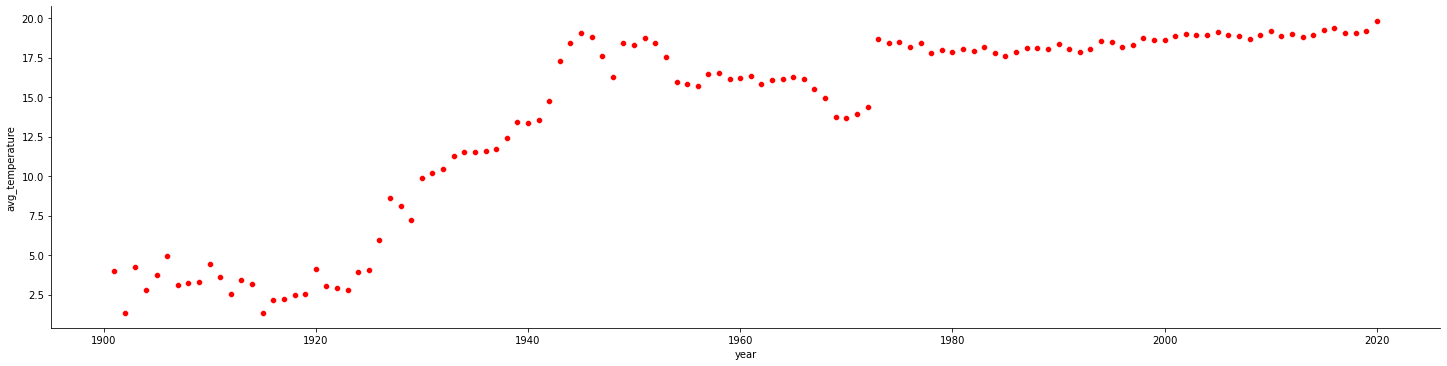

In [22]:
plt.figure(figsize=(24,6))
sns.relplot(data=yearly_weather, x="year", y="avg_temperature", color="r", aspect=4)

That looks fishy. Maybe the number of weather stations significantly changed over time?

In [11]:
yearly_countries = daily_country_weather \
    .withColumn("year", f.year(f.col("date"))) \
    .groupBy("year").agg(
        f.countDistinct(f.col("CTRY")).alias("num_countries")
    )\
    .orderBy(f.col("year")).toPandas()

<Figure size 1728x432 with 0 Axes>

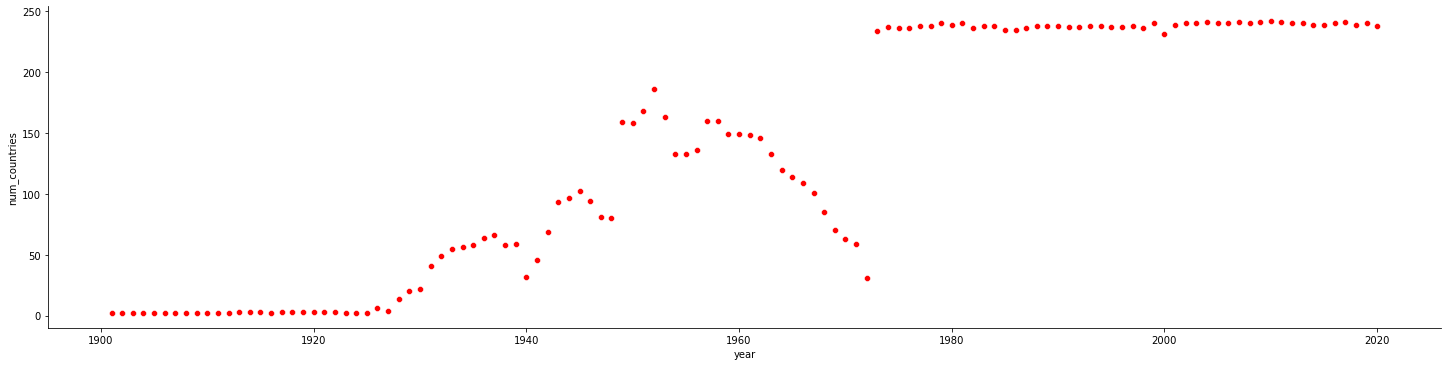

In [20]:
plt.figure(figsize=(24,6))
sns.relplot(data=yearly_countries, x="year", y="num_countries", color="r", aspect=4)

## 7.2 Pick a Country

Since the last plot looks very suspicious, let's concentrate on a single country. We pick a single country (in my case Germany). Remember that the country codes are FIPS codes (https://en.wikipedia.org/wiki/List_of_FIPS_country_codes)

In [25]:
country = "GM"

In [29]:
# Read in data again and filter for selected country
daily_country_weather = spark.read.parquet(daily_country_weather_location).filter(f.col("CTRY") == country)

## 7.3 Yearly Average Temperature per Country

Now we can calculate the average temperature per year of the selected country.

In [30]:
yearly_weather = daily_country_weather \
    .withColumn("year", f.year(f.col("date"))) \
    .groupBy("year").agg(
        f.avg(f.col("avg_temperature")).alias("avg_temperature"),
        f.avg(f.col("avg_wind_speed")).alias("avg_wind_speed"),
        f.avg(f.col("max_wind_speed")).alias("max_wind_speed")
    )\
    .orderBy(f.col("year")).toPandas()

<AxesSubplot:xlabel='year', ylabel='avg_temperature'>

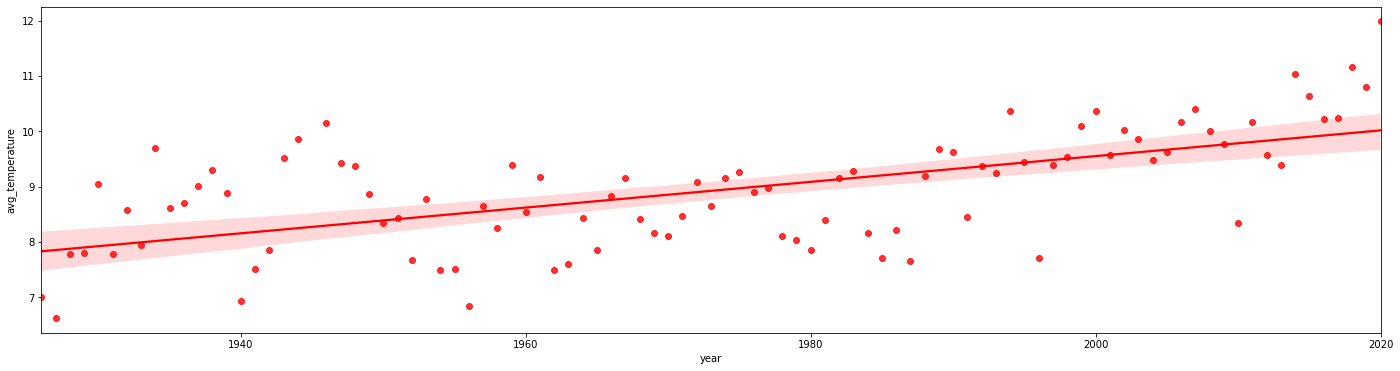

In [31]:
plt.figure(figsize=(24,6))
sns.regplot(data=yearly_weather, x="year", y="avg_temperature", color="r")

Even without fitting the red line, a trend is clearly visible with much higher average temperatures within the last years. And rest assured, from my own experience as a person living in Germany I can only confirm that this is correct.

### Average and Maximum Wind Speed

It would also be interesting to see how the wind speed has changed over time. I am interested both in the average and in the maximum wind speed.

<AxesSubplot:xlabel='year', ylabel='max_wind_speed'>

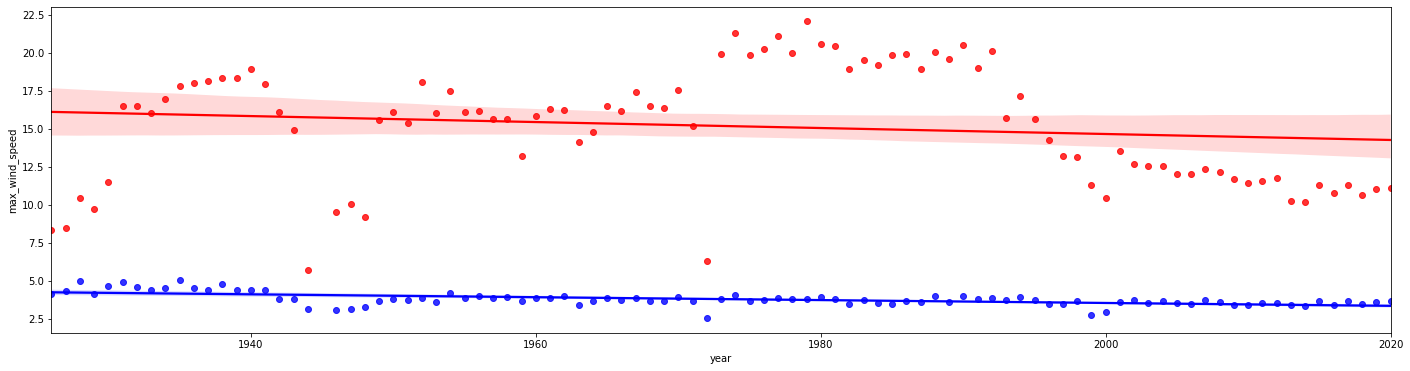

In [57]:
plt.figure(figsize=(24,6))
sns.regplot(data=yearly_weather, x="year", y="avg_wind_speed", color="b")
sns.regplot(data=yearly_weather, x="year", y="max_wind_speed", color="r")

Honestly the result isn't very convincing and doesn't reflect my impression that the number of storms has increased. But eventually both metrics (the maximum and the average) probably aren't the best way to measure an increase in storms. Better ideas are needed here.

## 7.4 Monthly Average Temperatures per Country

First let's have a look how the temperatures of each month has developed over time.

https://www.dwd.de/DE/leistungen/zeitreihen/zeitreihen.html#buehneTop

In [58]:
df = daily_country_weather \
    .withColumn("month", f.month(f.col("date"))) \
    .withColumn("year", f.year(f.col("date"))) \
    .orderBy(f.col("date")).toPandas()

<AxesSubplot:xlabel='year', ylabel='avg_temperature'>

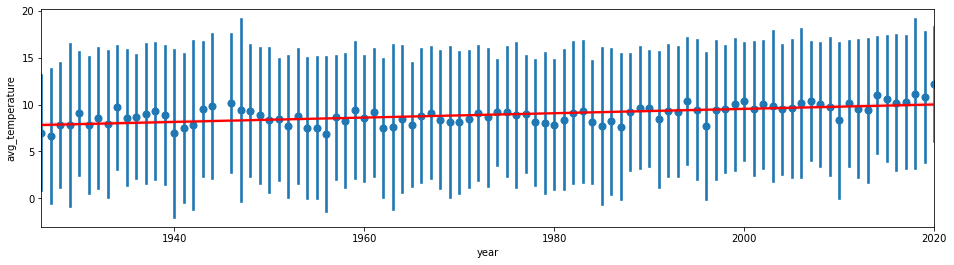

In [79]:
plt.figure(figsize=(16,4))
sns.regplot(data=df, x="year", y="avg_temperature", x_estimator=np.mean, x_ci="sd", ci=100, fit_reg=True, lowess=False, line_kws={'color':'red'})

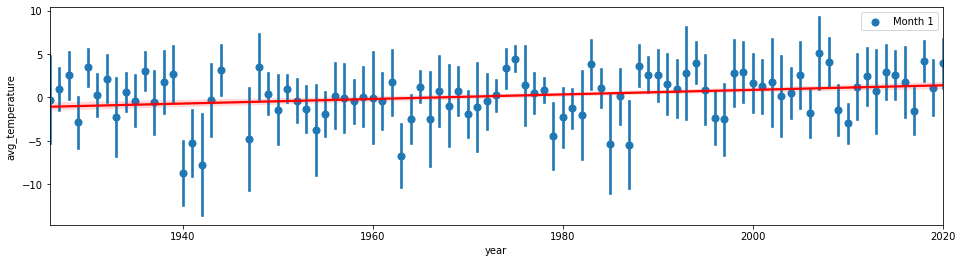

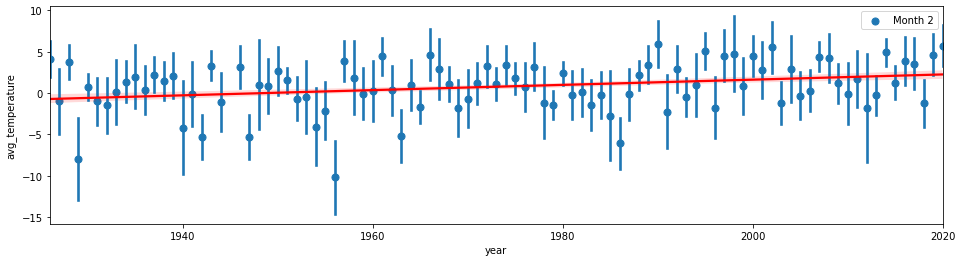

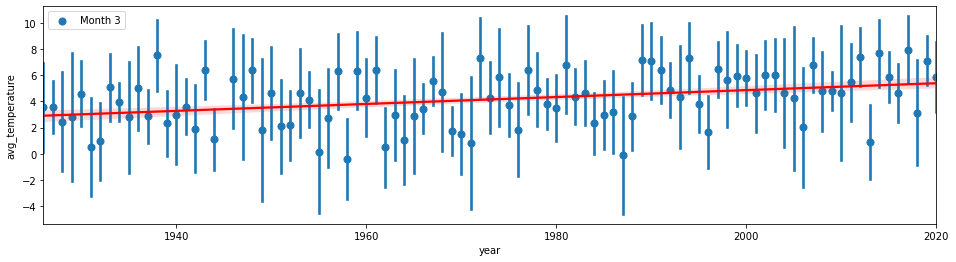

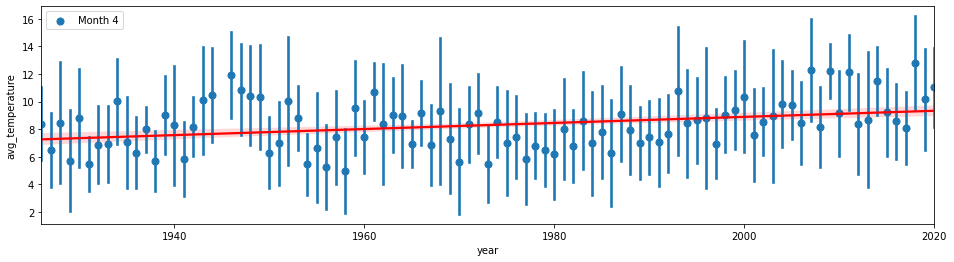

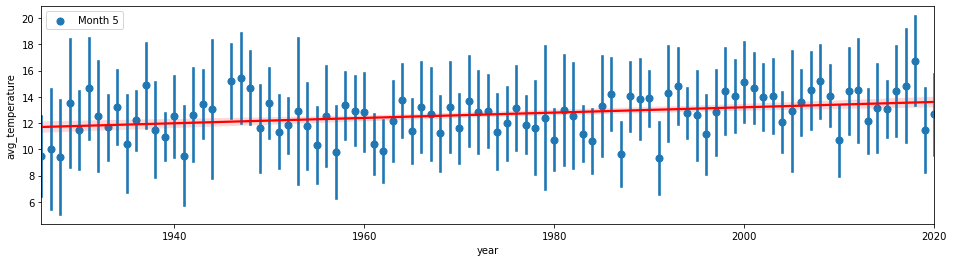

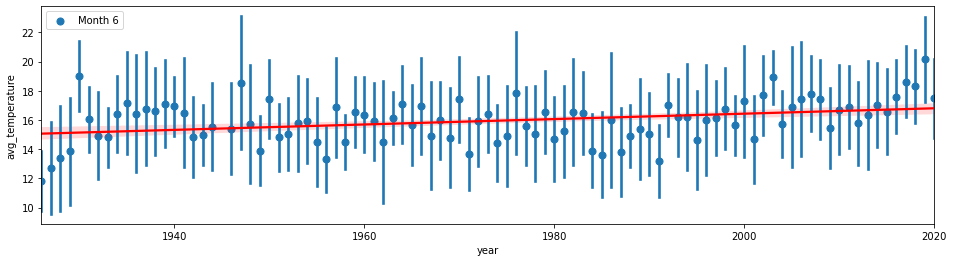

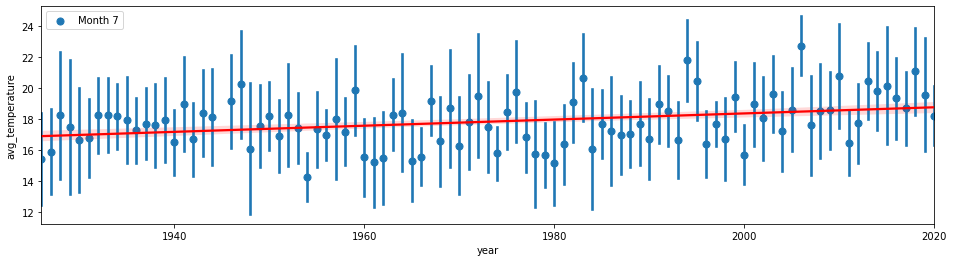

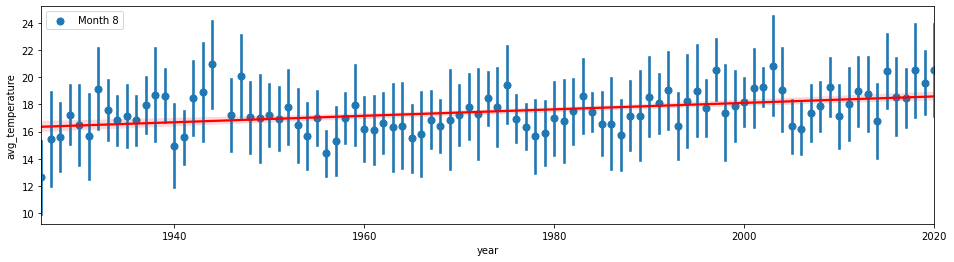

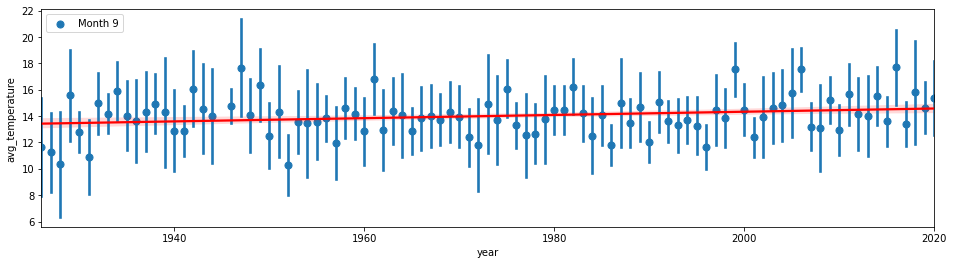

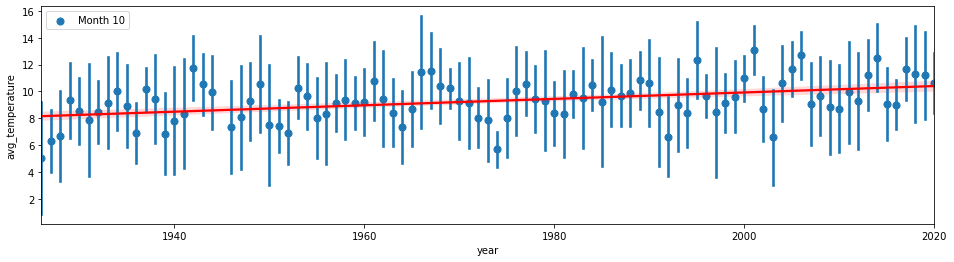

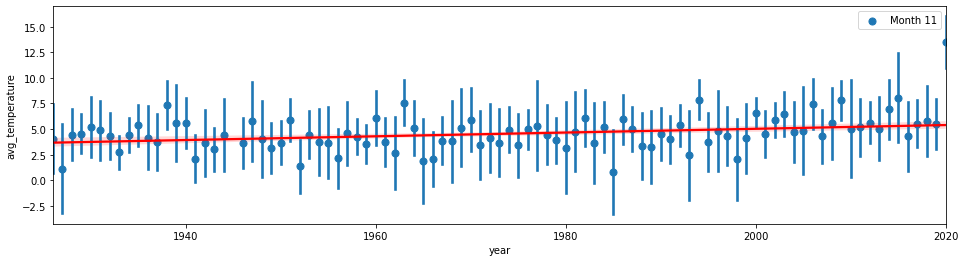

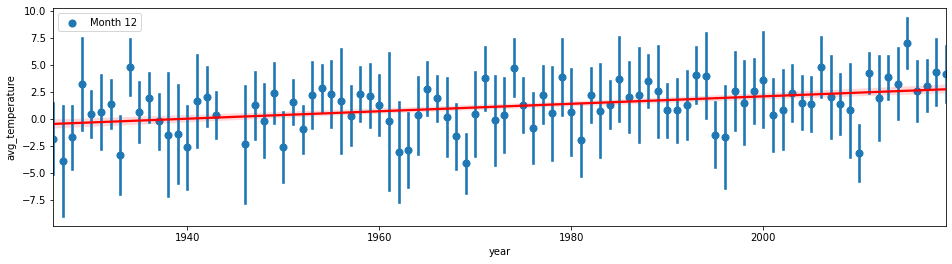

In [80]:
for m in range(1,13):
    data = df[df["month"] == m]
    plt.figure(figsize=(16,4))
    sns.regplot(data=data, x="year", y="avg_temperature", x_estimator=np.mean, x_ci="sd", ci=100, lowess=False, line_kws={'color':'red'}, label="Month " + str(m))
    plt.legend()

## 7.5 Monthly Average Temperature per Country

In [32]:
monthly_country_weather = daily_country_weather.groupBy("CTRY", "STATE", f.year("date").alias("year"), f.month("date").alias("month")).agg(
        f.min(f.col("min_temperature")).alias("min_temperature"),
        f.max(f.col("max_temperature")).alias("max_temperature"),
        f.avg(f.col("avg_temperature")).alias("avg_temperature"),
        f.stddev(f.col("avg_temperature")).alias("stddev_temperature"),
        f.min(f.col("min_wind_speed")).alias("min_wind_speed"),
        f.max(f.col("max_wind_speed")).alias("max_wind_speed"),
        f.avg(f.col("avg_wind_speed")).alias("avg_wind_speed"),
        f.min(f.col("date")).alias("date"),
    )

df = monthly_country_weather.orderBy("date").toPandas()
df.head()

,CTRY,STATE,year,month,min_temperature,max_temperature,avg_temperature,stddev_temperature,min_wind_speed,max_wind_speed,avg_wind_speed,date
0,GM,None,1926,1,-15.0,8.9,-0.265591,5.049171,0.0,12.3,3.361290,1926-01-01
1,GM,None,1926,2,-3.9,10.0,4.090476,2.190100,0.0,15.4,2.312500,1926-02-01
2,GM,None,1926,3,-3.9,17.2,3.537366,3.477344,0.0,15.4,3.656452,1926-03-01
3,GM,None,1926,4,-1.1,23.9,8.381944,2.691542,0.0,22.6,2.367222,1926-04-01
4,GM,None,1926,5,-2.2,23.9,9.476801,3.112531,0.0,15.4,3.546989,1926-05-01


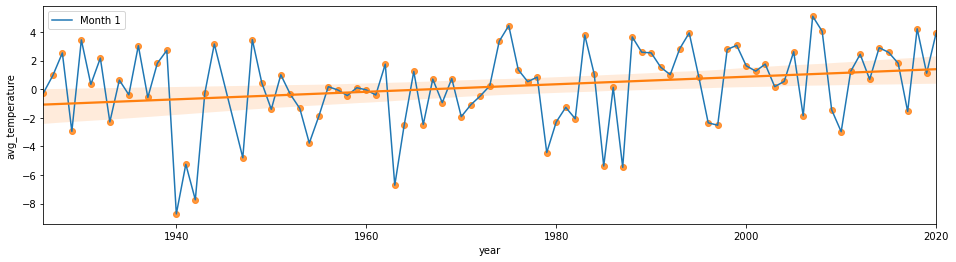

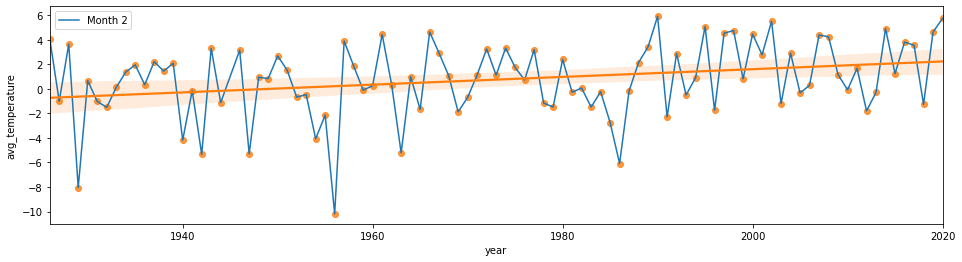

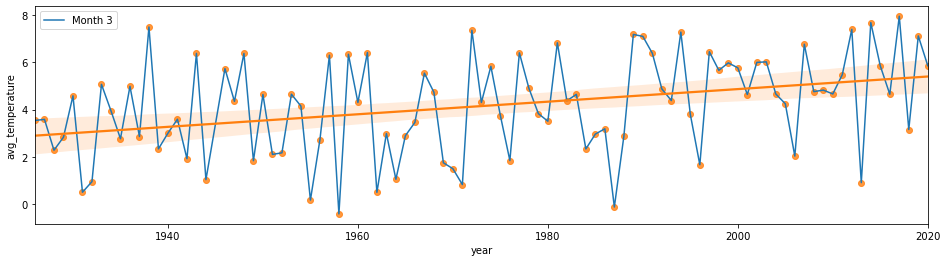

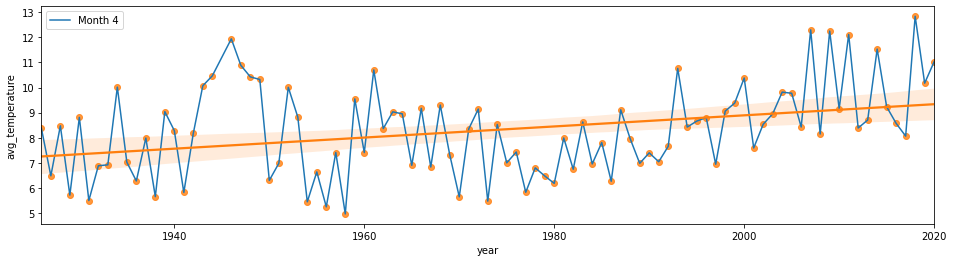

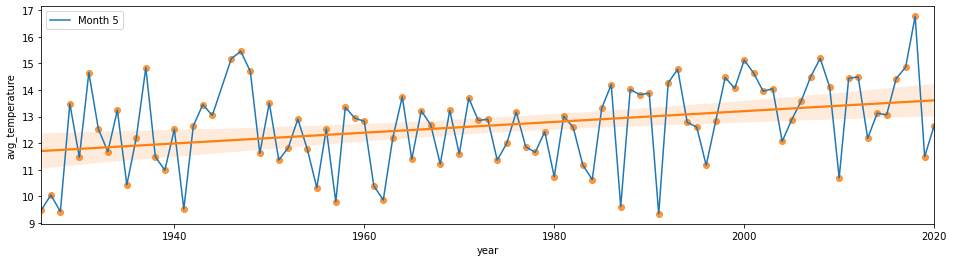

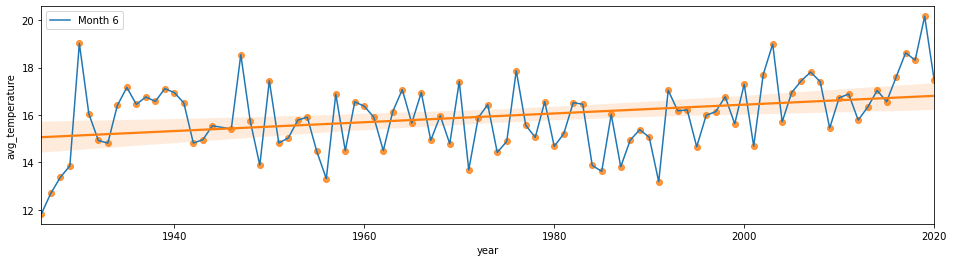

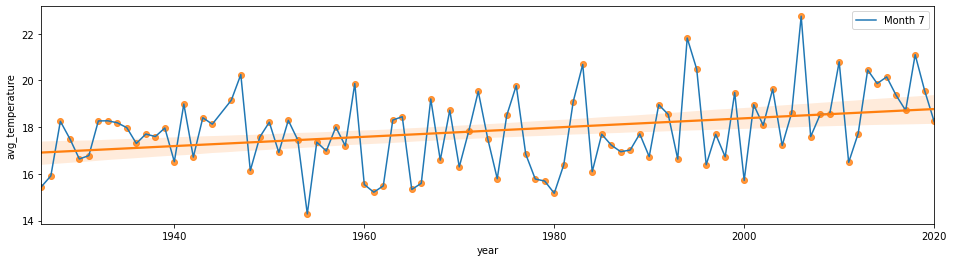

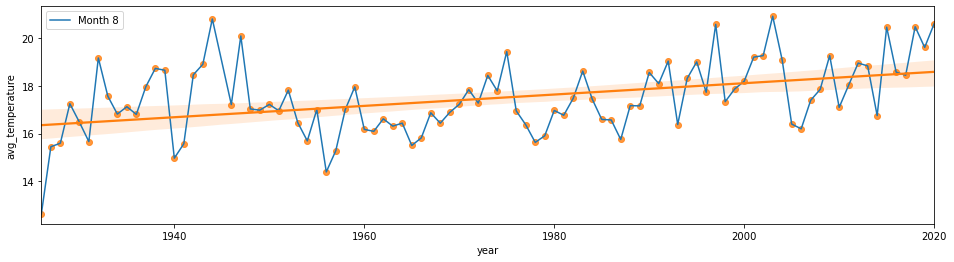

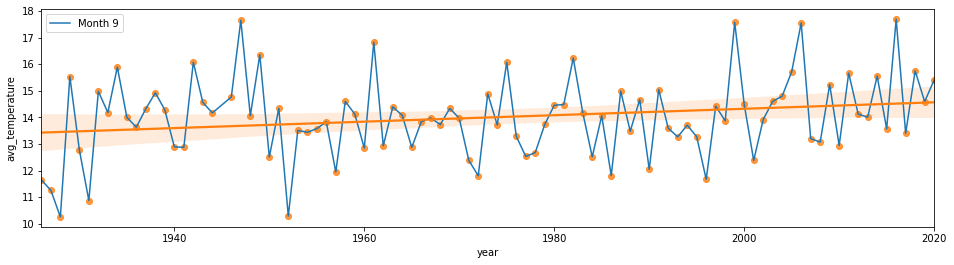

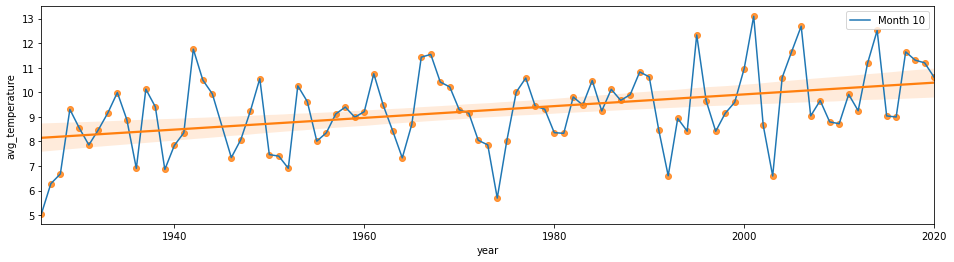

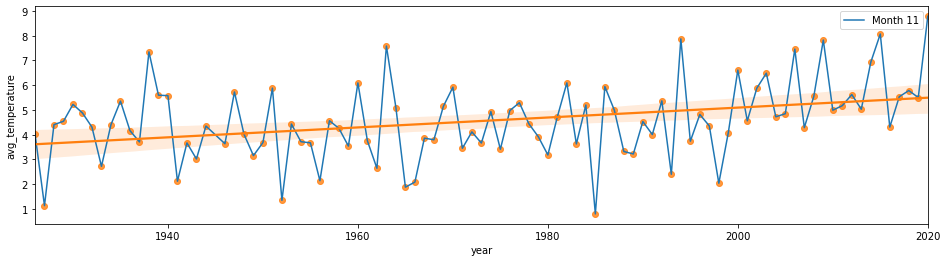

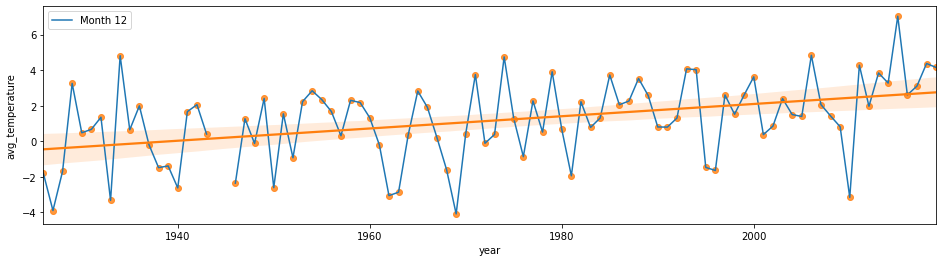

In [33]:
for m in range(1,13):
    data = df[df["month"] == m]
    plt.figure(figsize=(16,4))
    plt.plot(data["year"], data["avg_temperature"], label="Month " + str(m))
    plt.legend()
    sns.regplot(data=data, x="year", y="avg_temperature")#, aspect=3)


## 7.6 Histograms

A different approach to visualize the shift in temperatur could be to use histograms.

In [81]:
monthly_weather = daily_country_weather \
    .withColumn("month", f.month(f.col("date"))) \
    .withColumn("year", f.year(f.col("date"))) \
    .filter(f.col("CTRY") == country)\
    .orderBy(f.col("date")).toPandas()

yearly_weather = monthly_weather.groupby("year").mean()

<AxesSubplot:xlabel='year', ylabel='avg_temperature'>

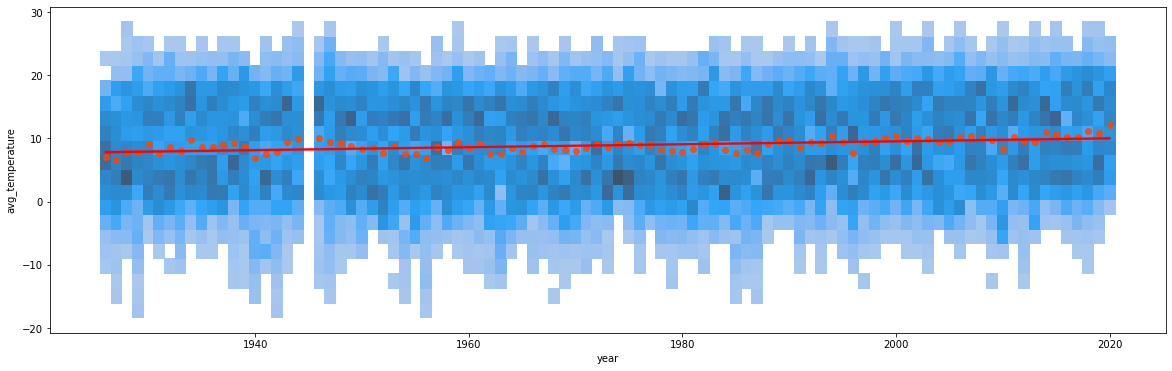

In [88]:
plt.figure(figsize=(20,6))
sns.histplot(
    monthly_weather, x="year", y="avg_temperature",
    bins=20, discrete=(True, False), log_scale=(False, False),
    cbar=False, cbar_kws=dict(shrink=.75),
)
sns.regplot(data=yearly_weather, x=yearly_weather.index, y="avg_temperature", line_kws={'color':"r"}, scatter_kws={'color':'orangered'})